In [2]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
width = height = 128
device = "cuda"

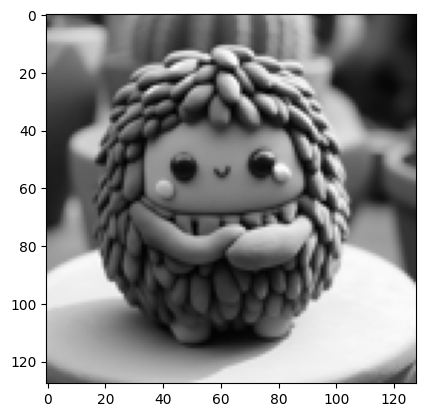

In [12]:
target_image = Image.open("test.png")

target_image = target_image.convert("L").resize((height, width))
plt.imshow(target_image, cmap="grey")
plt.show()

target_image = transforms.ToTensor()(target_image).to(device).squeeze(0)

In [13]:
target_image.shape

torch.Size([128, 128])

In [19]:
from gaussian_model import Gaussian2DImage, combined_loss
from IPython.display import clear_output

num_gaussians = 1000

num_steps = 7000
dump_every = 100
reset_every = 3000
densify_from = 500
densify_until = 15000
densify_every = 100

In [24]:
def optimization_loop(gaussian_image):

    gaussian_image.create_optimizer()
    
    for step in range(num_steps):
    
        gaussian_image.optimizer.zero_grad()

        reconstructed_image = gaussian_image()

        loss = combined_loss(reconstructed_image, target_image, lambda_param=0.2)
        loss.backward()
    
        if loss < 1e-5:
            print(f"Small loss at iter {step}")
            break
    
        if loss.isnan():
            print(f"NaNs at iter {step}")
            break
    
        gaussian_image.optimizer.step()
        gaussian_image.update_learning_rate(step)
        
        if step % dump_every == 0:
            clear_output(wait=True)
            
            result = torch.cat([
                reconstructed_image.unsqueeze(0), 
                target_image.unsqueeze(0), 
                torch.sqrt((reconstructed_image - target_image) ** 2).unsqueeze(0)
            ], dim=2)
            result = transforms.ToPILImage()(result)
            
            plt.figure(figsize=(10, 5))
            plt.imshow(result, cmap="grey")
            plt.title(f"step: {step}")
            plt.show()
    
        if step < densify_until:
            # clone and split gaussians
            if step > densify_from and step % densify_every == 0:
                gaussian_image.densify_and_prune(scale_threshold=3)
        
            # reset opacities
            if step > 0 and step % reset_every == 0:
                gaussian_image.reset_opacity()

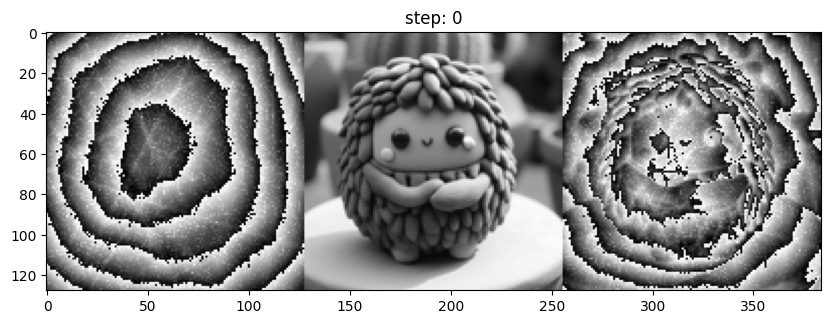

In [ ]:
gaussian_image = Gaussian2DImage(num_gaussians, width, height).to(device)
optimization_loop(gaussian_image)